# Covid-19 Situation in San Diego
I keep checking [San Diego County's Covid-19 webpage](https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html) for up-to-date stats. I'm interested in the number of new cases per day, since that's what tells us if Covid-19 is spreading at an exponential rate (which would be _really_ scary – see [Simulating an epidemic](https://www.youtube.com/watch?v=gxAaO2rsdIs) by Grant Sanderson of 3blue1brown). The county website has new cases per day already, so perfect, right? The thing is, if you check the number of new _tests_ by day, you'll see that it looks awfully like the number of new cases per day. Now what I'm wondering is whether the new cases per day is indicative of _actual_ new cases or only the number of tests.

First let's get the data.

In [1]:
import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

figsize = (15, 3)

We can find the query URL [here](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county?orderBy=date&orderByAsc=false&selectedAttribute=tests). SANDAG has some amazing datasets with great documentation by the way. I'd highly suggest anyone interested in Data Science who lives in the San Diego area to go check out the other data sets they have.

In [2]:
query_url = 'https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/COVID_19_Statistics_San_Diego_County/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
response = requests.get(query_url)

if response.status_code == 200:
    print('Successfully ran API query')

Successfully ran API query


In [3]:
response.json().keys()

dict_keys(['exceededTransferLimit', 'features', 'fields', 'geometryType', 'spatialReference', 'globalIdFieldName', 'objectIdFieldName', 'hasZ', 'hasM'])

Alright, most of those are just extra metadata. What we care about is in `features`.

In [4]:
len(response.json()['features'])

75

We have one entry per day since mid-March when California started quarantining.

In [5]:
# we're working with such a small dataset that we don't have to worry about computation time.
# It'd probably take me longer to optimize than the time I'd save optimizing.
example = response.json()['features'][0]
cols = example['attributes'].keys()
df = pd.DataFrame(columns=cols)

for feature in response.json()['features']:
    df = df.append(pd.Series(feature['attributes']), ignore_index=True)

#df.set_index('objectid', inplace=True)
df.sort_values('date', inplace=True)

df.head()

,objectid,date,tests,positives,hospitalized,icu,deaths,newcases,age_9,age10_19,...,age80_plus,ageunknow,age20_29,genderfemale,gendermale,gendeunk,age30_39,globalid,newtests,rolling_perc_pos_cases
31,87,1583568000000,None,1,0,0,0,1,None,None,...,None,None,None,None,None,None,None,{CE98E5A7-7D8E-4D20-BC84-069A17D43232},None,None
32,88,1583654400000,None,2,0,0,0,1,None,None,...,None,None,None,None,None,None,None,{8AC07123-E9DA-4D83-9720-7BF93E4B6C44},None,None
33,89,1583740800000,None,2,0,0,0,0,None,None,...,None,None,None,None,None,None,None,{52083240-452D-41A6-BD0F-2D424B2745BC},None,None
34,90,1583827200000,None,4,0,0,0,2,None,None,...,None,None,None,None,None,None,None,{9DF87361-2D53-4A06-8DF9-A986B660061D},None,None
3,59,1583913600000,123,5,None,None,None,1,None,None,...,None,None,None,None,None,None,None,{78698F35-A6E9-48CB-8C8D-67A70EC15C1D},None,None


Alright, data is there, but not exactly in the format we want.

First, let's convert the date from an integer to a datetime. I'm not completely familiar with ARCGIS data but the metadata says this is of type esriFieldTypeDate with length 29. A [post on StackOverflow](https://stackoverflow.com/questions/17231711/how-to-create-datetime-from-a-negative-epoch-in-python/17231712) shows us how to convert this into a datetime object.

In [6]:
datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(1583568000000/1000))

datetime.datetime(2020, 3, 7, 8, 0)

Let's double check this. On the [data page](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county/data?orderBy=date&orderByAsc=false&selectedAttribute=tests) we see that objectid 133 is May 21.

In [7]:
datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(df[df['objectid'] == 133].date.values[0]/1000))

datetime.datetime(2020, 5, 20, 8, 0)

The hours are a little off (should be 1:00AM), but this is fine since we only care about the day.

In [8]:
df['date'] = df['date'].apply(lambda x: datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(x/1000)))
df['date_str'] = df['date'].dt.strftime('%m/%d')
df.sort_values('date', inplace=True)

We also want to today's deaths - not just the total.

In [79]:
df['deaths_today'] = df['deaths'] - df.shift(periods=1)['deaths']

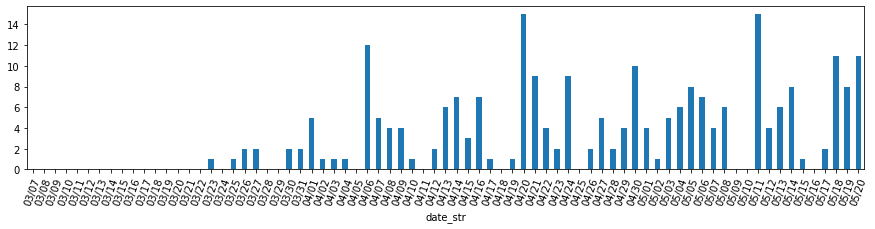

In [92]:
plot_by_time('deaths_today')

In [9]:
df.head()

,objectid,date,tests,positives,hospitalized,icu,deaths,newcases,age_9,age10_19,...,ageunknow,age20_29,genderfemale,gendermale,gendeunk,age30_39,globalid,newtests,rolling_perc_pos_cases,date_str
31,87,2020-03-07 08:00:00,None,1,0,0,0,1,None,None,...,None,None,None,None,None,None,{CE98E5A7-7D8E-4D20-BC84-069A17D43232},None,None,03/07
32,88,2020-03-08 08:00:00,None,2,0,0,0,1,None,None,...,None,None,None,None,None,None,{8AC07123-E9DA-4D83-9720-7BF93E4B6C44},None,None,03/08
33,89,2020-03-09 08:00:00,None,2,0,0,0,0,None,None,...,None,None,None,None,None,None,{52083240-452D-41A6-BD0F-2D424B2745BC},None,None,03/09
34,90,2020-03-10 08:00:00,None,4,0,0,0,2,None,None,...,None,None,None,None,None,None,{9DF87361-2D53-4A06-8DF9-A986B660061D},None,None,03/10
3,59,2020-03-11 08:00:00,123,5,None,None,None,1,None,None,...,None,None,None,None,None,None,{78698F35-A6E9-48CB-8C8D-67A70EC15C1D},None,None,03/11


Okay, now that we have the data in the format we want it, let's try our first approach. Let's just overlay the two graphs:

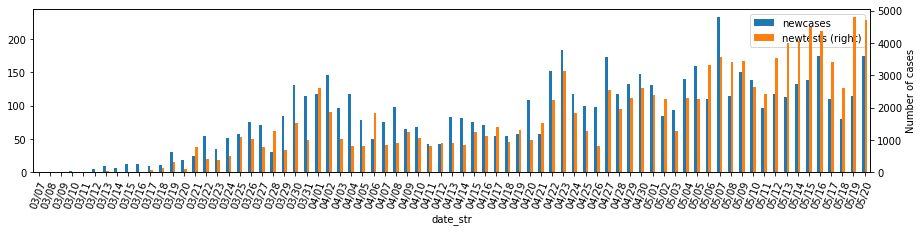

In [11]:
df.set_index('date_str')[['newcases', 'newtests']].plot.bar(figsize=figsize, secondary_y= 'newtests', rot=70)
plt.ylabel('Number of cases')
plt.xlabel('Date');

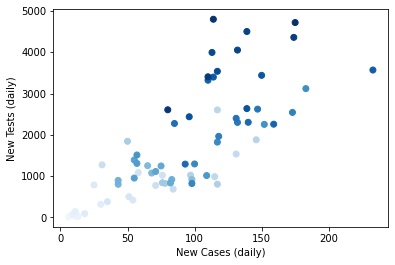

In [12]:
plt.scatter(df['newcases'].values, df['newtests'].values, c=df['objectid']/df['objectid'].max(), cmap='Blues')
plt.ylabel('New Tests (daily)')
plt.xlabel('New Cases (daily)');

Both plots definitely show some correlation in there, which makes sense. Since we can't just test everyone, ...

Next thoughts:
* https://www.youtube.com/watch?v=mCa0JXEwDEk
* https://www.youtube.com/watch?v=54XLXg4fYsc

In [14]:
df.columns

Index(['objectid', 'date', 'tests', 'positives', 'hospitalized', 'icu',
       'deaths', 'newcases', 'age_9', 'age10_19', 'age40_49', 'age50_59',
       'age60_69', 'age70_79', 'age80_plus', 'ageunknow', 'age20_29',
       'genderfemale', 'gendermale', 'gendeunk', 'age30_39', 'globalid',
       'newtests', 'rolling_perc_pos_cases', 'date_str'],
      dtype='object')

In [16]:
df['total_cases'] = df['newcases'].cumsum()

In [86]:
def plot_by_time(col):
    df.set_index('date_str')[col].plot.bar(figsize=figsize, rot=70)

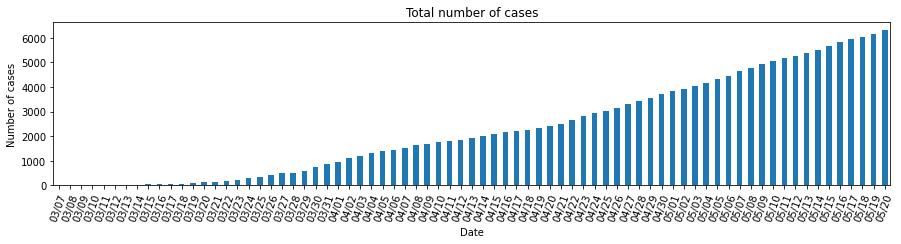

In [87]:
plot_by_time(col='total_cases')
plt.title('Total number of cases')
plt.ylabel('Number of cases')
plt.xlabel('Date');

In [31]:
# test out our formula - we should get a doubling rate of 1 day
q1 = 100
q2 = 200
time_delta = 1 # days

time_delta * np.log(2) / np.log(q2/q1)

1.0

<ipython-input-95-932b256571a7>:3: RuntimeWarning: divide by zero encountered in true_divide
  df['days_to_double'] = time_delta * np.log(2) / np.log(np.array(df.shift(periods=-time_delta)['total_cases'], dtype=float) / np.array(df['total_cases'], dtype=float))


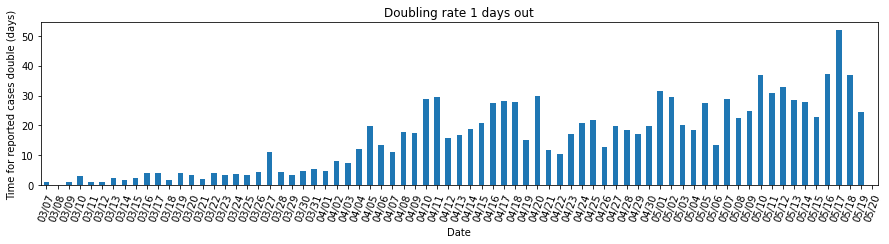

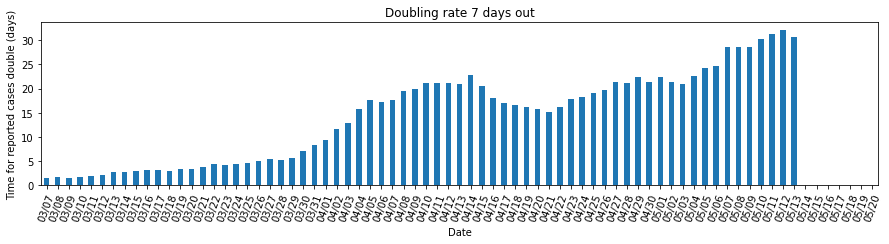

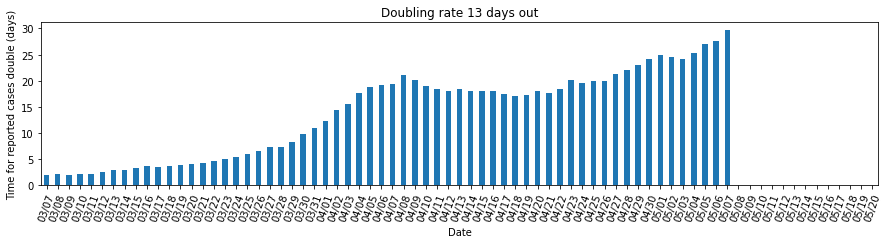

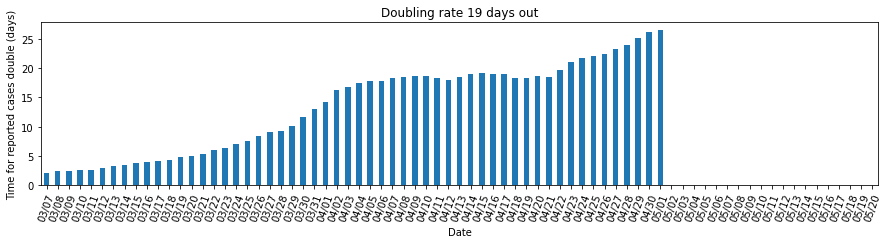

In [95]:
for i in range(1, 20, 6):
    time_delta = i # days
    df['days_to_double'] = time_delta * np.log(2) / np.log(np.array(df.shift(periods=-time_delta)['total_cases'], dtype=float) / np.array(df['total_cases'], dtype=float))
    
    plt.figure()
    plt.title(f'Doubling rate {i} days out')
    plot_by_time('days_to_double')
    plt.ylabel('Time for reported cases double (days)')
    plt.xlabel('Date');

In [51]:
# we'll choose a spread of 7 days
time_delta = 7 # days
df['days_to_double'] = time_delta * np.log(2) / np.log(np.array(df.shift(periods=-time_delta)['total_cases'], dtype=float) / np.array(df['total_cases'], dtype=float))

In [60]:
mortality_rate = 0.01 # 1%
infection_to_death_time = 20 # days

In [69]:
# example
deaths_today = 3
doubling_time_days = 10

cases_20_days_ago = deaths_today / mortality_rate
number_of_times_doubled = infection_to_death_time / doubling_time_days
cases_estimate_by_deaths = np.exp2(number_of_times_doubled) * cases_20_days_ago

print(f'There were {deaths_today} deaths today meaning there were {cases_20_days_ago} cases_20_days_ago.\n' + 
      f'Since then the number of cases doubled {number_of_times_doubled} times, so there should be {cases_estimate_by_deaths} actual cases today.')

There were 3 deaths today meaning there were 300.0 cases_20_days_ago.
Since then the number of cases doubled 2.0 times, so there should be 1200.0 actual cases today.


In [82]:
df['estimated_total_cases'] = df.apply(lambda row:
         np.exp2(infection_to_death_time / row['days_to_double']) * row['deaths_today'] / mortality_rate
         ,axis=1
)

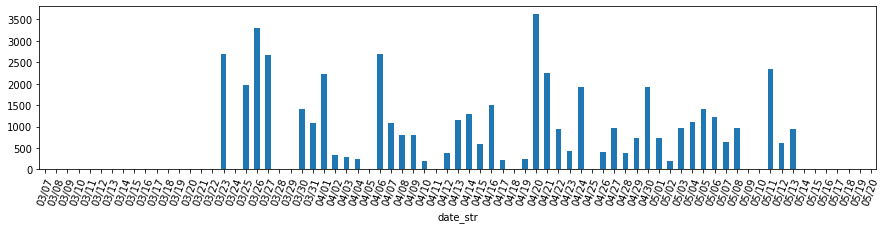

In [90]:
plot_by_time('estimated_total_cases')